# Предметная область

Для исследования был выбран датасет .

Основная задача:
- Понять какие группы клиентов более склонны к уходу и найти возможные причины

Признаки:
1. CustomerId - уникальная числовая последовательность характеризующая отдельного клиента
2. Surname - фамилия клиента
3. CreditScore - числовой показатель, показывающий кредитоспособность человека
4. Geography - местоположение клиента (скорее всего страна, нужно проверить)
5. Gender - пол клиента
6. Age - возвраст клиента
7. Tenure - срок пользования услугами банка (скорее всего в годах, нужно проверить)
8. Balance - баланс клиента
9. NumOfProduct - количество активных кредитных/банковских карт у клиента
10. HasCrCard - имеет ли клиент кредитные карты
11. IsActiveMember - является ли клиент активным пользователем
12. EstimatedSalary - предполагаемая зарплата клиента
13. Exited - Отказался ли клиент от услуг банка

# Первичный анализ данных

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv(r"..\data\raw\Churn_Modelling.csv", sep=',',index_col="RowNumber")
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Интересна ситуация, когда клиент является активным, но при этом отказался от услуг банка. Предположения следующие:
1. Активностью считается вход в приложение банка или на сайт (в таком случае можно провести также классификацию на клиентов, которые могли бы вернуться)
2. Активность клиента проверялась раз в некоторый дискретный период времени. И система оценила клиента как активно, после чего он ушел.

Также интересно, что присутствуют клиенты ушедшие из банка, но имеющие довольно значительный баланс

In [4]:
print("Количество строк: {}\nКоличество признаков: {}".format(df.shape[0], df.shape[1]))

Количество строк: 10000
Количество признаков: 13


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


- Пропущенных значений в данных нет
- Все признаки имеют нужный тип данных (единственное булевы переменные хранятся как int)

In [6]:
df.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


- По распределению Tenure видно, что скорее всего этот признак измеряется в годах (что менее информативно)
- Как минимум 25% клиенов имеют нулевые балансы - что может говорить о высоком недоверии (нужно проверить корреляцию с активностью и уходом)
- По распределению CreditScore видно, что оно измеряется по шкале FICO Score:
    - 800+ — исключительный рейтинг (минимальный риск для кредиторов).
    - 740–799 — очень хороший.
    - 670–739 — хороший (средний уровень).
    - 580–669 — удовлетворительный (повышенный риск).
    - <580 — плохой (высокий риск дефолта).
- Всего 20% клиентов отказались от услуг банка (распределение неравномерное, поэтому нужно будет исследовать группы по отдельности)

# Препроцессинг и очистка

Итак, пропущенных данных у нас нет. Сейчас будем смотреть на дублирующиеся строки, искать выборосы, а также возможно заменим числовые показатели CreditScore и Age на категориальные, разбив на корзины. 

In [7]:
print("Дублирующиеся строки {}.".format("присутствуют" if df.duplicated().any() else "отсутствуют"))

Дублирующиеся строки отсутствуют.


In [8]:
print("Количество уникальных CustomerId: {}".format(df["CustomerId"].nunique()))

Количество уникальных CustomerId: 10000


Так как каждая строка представляет уникального пользователя, уберем признаки CustomerId и Surname за ненадобностью

In [9]:
df_processed = df.drop(columns=["CustomerId", "Surname"])

In [10]:
NumericColmuns = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "EstimatedSalary"]
BooleanColumns = ["HasCrCard", "IsActiveMember"]
CategoricalColumns = ["Geography","Gender"]
Target = "Exited"

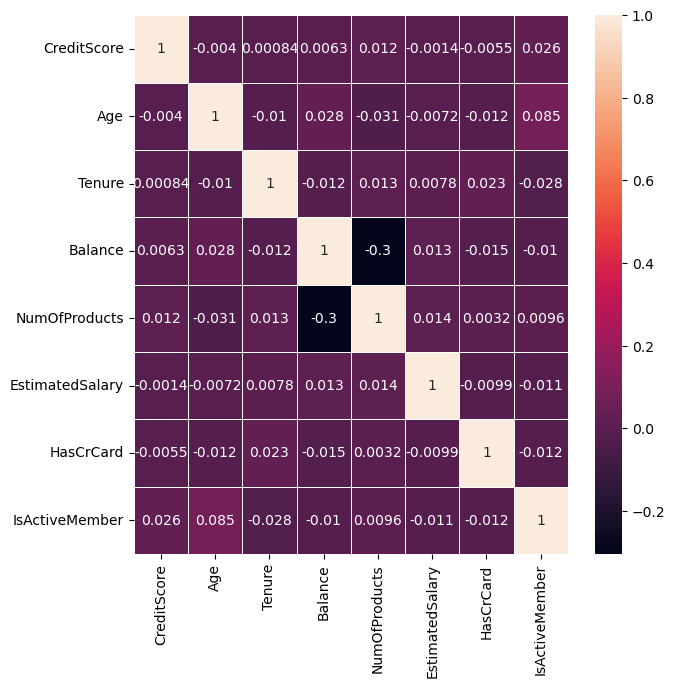

In [11]:
plt.figure(figsize=(7,7))
sns.heatmap(df[NumericColmuns+BooleanColumns].corr(), annot=True, linewidth=.5)
plt.show()

Признаки почти не зависят друг от друга, только количество продуктов имеет небольшую отрицательную корреляцию относительно баланса, что интересно, но малоинформативно

Построим ящики с усами для всех числовых признаков

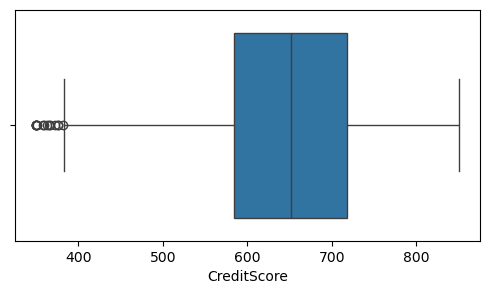

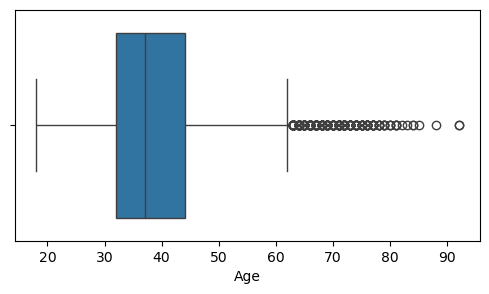

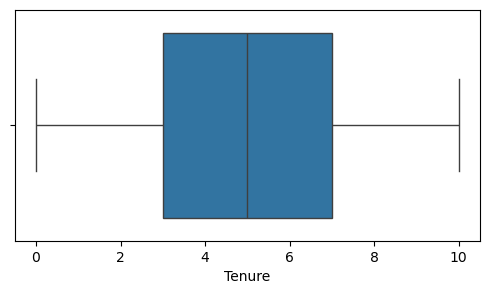

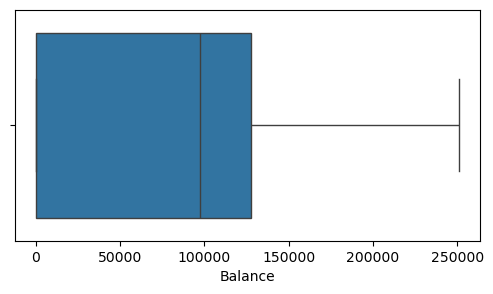

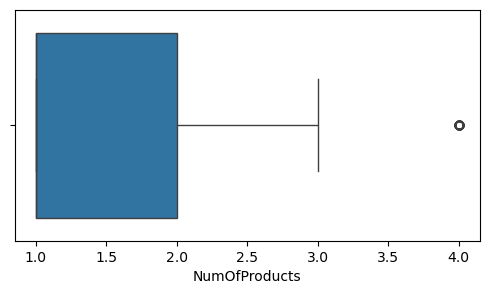

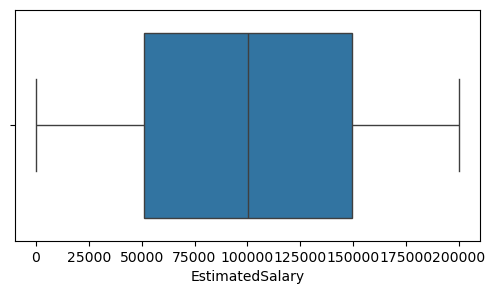

In [12]:
for i, numCol in enumerate(NumericColmuns):
    plt.figure(i,figsize=(6,3))
    sns.boxplot(data = df_processed, x = numCol)
    plt.show()
    
    # plt.figure(i,figsize=(5,4))
    # sns.histplot(data = df_processed, x=numCol)
    # plt.show()

Видно, что есть некоторые очень взрослые клиенты, поэтому для анализа разделим признак Age на группы по возрасту:
- <25 
- [25, 35) 
- [35, 45) 
- [45, 55)
- \>=55 

CreditScore разделим так, как описывалось выше. 

С остальными числовыми переменными все в порядке.

Можно подумать по поводу разделения Balance на корзины, но для начала нужно будет посмотреть на гистограмму.

In [13]:
age_cut_labels = ['<25', '25-34', '35-44', '45-54', ">=55"]
age_cut_bins = [0, 25, 35, 45, 55, 150]

df_processed["AgeBin"] = pd.cut(df_processed["Age"], bins=age_cut_bins, labels=age_cut_labels, right=False)

df_processed[["AgeBin","Age"]].head(5)

,AgeBin,Age
RowNumber,,
1,35-44,42
2,35-44,41
3,35-44,42
4,35-44,39
5,35-44,43


In [14]:
credit_cut_labels = ['Poor', 'Fair', 'Good', 'Very Good', "Exceptional"]
credit_cut_bins = [300, 580, 670, 740, 800, 851]

df_processed["CreditScoreBin"] = pd.cut(df_processed["CreditScore"], bins=credit_cut_bins, labels=credit_cut_labels, right=False)

df_processed[["CreditScoreBin","CreditScore"]].head(5)

,CreditScoreBin,CreditScore
RowNumber,,
1,Fair,619
2,Fair,608
3,Poor,502
4,Good,699
5,Exceptional,850


In [15]:
df_processed = df_processed.drop(columns=["CreditScore","Age"])

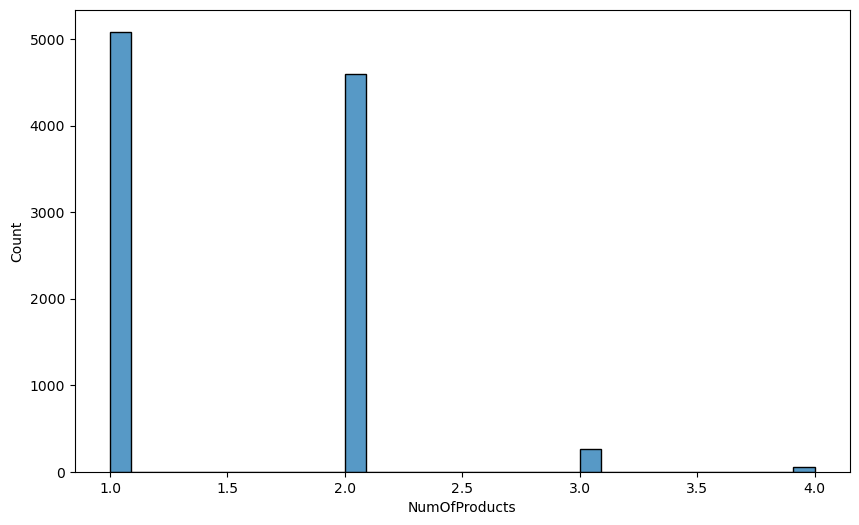

In [16]:
plt.figure(i, figsize=(10,6))
sns.histplot(df_processed, x="NumOfProducts")
plt.show()

In [17]:
size = df_processed.shape[0]   
OneProduct = df_processed["NumOfProducts"][df_processed["NumOfProducts"] == 1].count()
TwoProducts = df_processed["NumOfProducts"][df_processed["NumOfProducts"] == 2].count()
ThreeAndMoreProducts = df_processed["NumOfProducts"][df_processed["NumOfProducts"] >= 3].count()

print("Доля людей с одним продуктом: {}%".format(OneProduct/size*100))
print("Доля людей с двумя продуктами: {}%".format(TwoProducts/size*100))
print("Доля людей с тремя и более продуктами: {}%".format(ThreeAndMoreProducts/size*100))

Доля людей с одним продуктом: 50.839999999999996%
Доля людей с двумя продуктами: 45.9%
Доля людей с тремя и более продуктами: 3.26%


Видно, что у признака NumOfProducts смысл больше категориальный. Другой вопрос в том, имеет ли смысл разбивать их на 3 группы или лучше разбить на 2:
- 1 продукт.
- 2 и более.

На момент анализа будет информативнее оставить три категории, а в момент обучения предиктивной модели будет целесообразно проверить несколько вариантов.

In [18]:
numprods_cut_labels = ['1', '2', '>=3']
numprods_cut_bins = [0, 1, 2, 100]

df_processed["NumOfProductsBin"] = pd.cut(df_processed["NumOfProducts"], bins=numprods_cut_bins, labels=numprods_cut_labels)

df_processed[["NumOfProductsBin","NumOfProducts"]].head(5)

,NumOfProductsBin,NumOfProducts
RowNumber,,
1,1,1
2,1,1
3,>=3,3
4,2,2
5,1,1


In [19]:
df_processed = df_processed.drop(columns=["NumOfProducts"])

# Одномерный анализ

Посмотрим на распределение переменных само по себе, а также в зависимости от целевой переменной

In [20]:
NumericColmuns = ["Tenure", "Balance", "EstimatedSalary"]
BooleanColumns = ["HasCrCard", "IsActiveMember"]
CategoricalColumns = ["Geography","Gender", "AgeBin", "CreditScoreBin", "NumOfProductsBin"]

## Числовые признаки

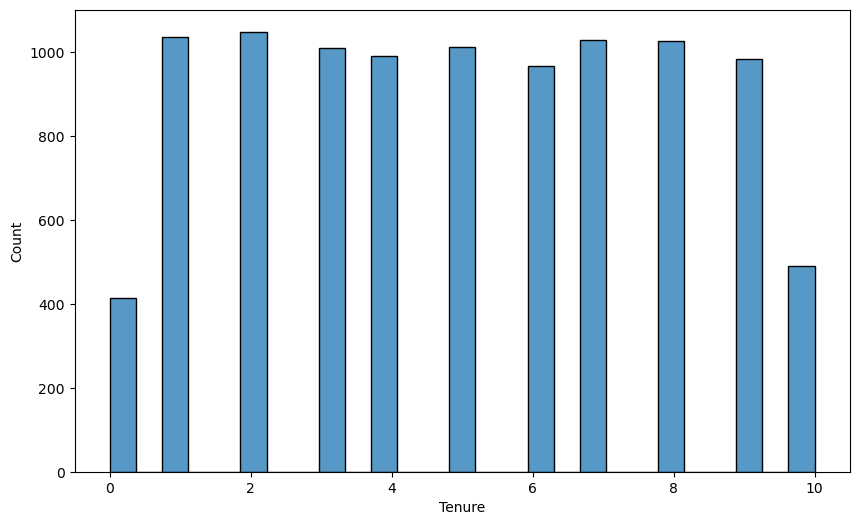

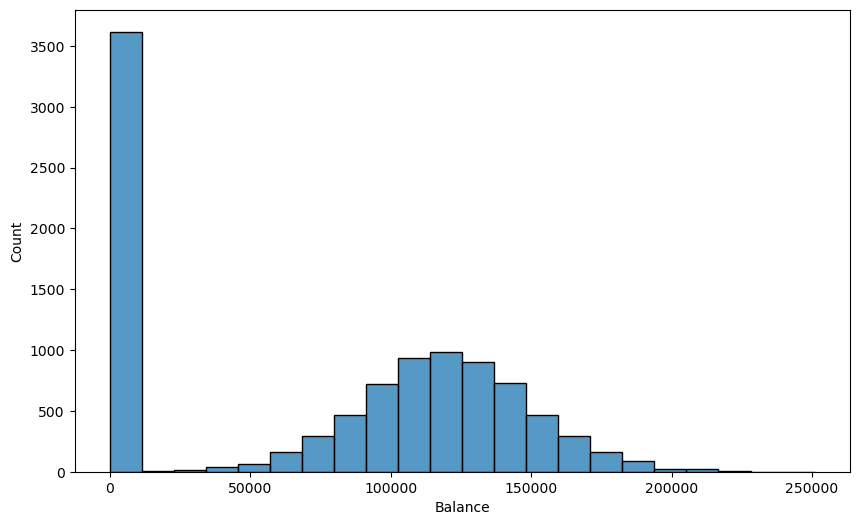

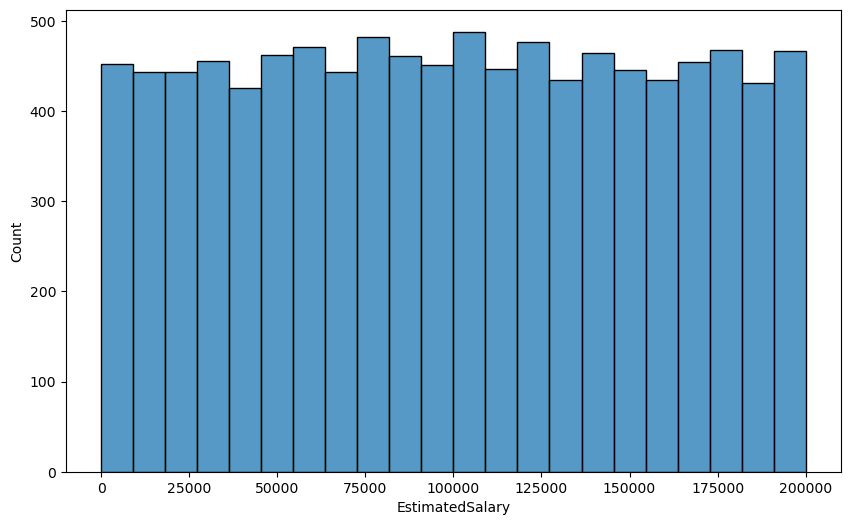

In [21]:
for i, numCol in enumerate(NumericColmuns):
    plt.figure(i, figsize=(10,6))
    sns.histplot(df_processed, x=numCol)
    plt.show()

Распределение Tenure почти равномерное, мое предположение, что изначально оно измерялось в днях или месяцах и было округленно при создании датасета, что привело к заниженным хвостам.

EstimatedSalary распределение равномерное.

Интереснее тут следующее: очень большое количество клиентов с нулевым балансом, а в остальном распределение нормальное.

In [22]:
print("Доля клиентов с нулевым балансом: {}%".format(df_processed["Balance"][df_processed["Balance"] == 0].count()/size*100))

Доля клиентов с нулевым балансом: 36.17%


В таком случае правильным будет отдельно анализировать клиентов с нулевым балансом, а на момент обучения модели протестировать с разными вариантами

In [23]:
zeroBalanceSize = df_processed[df_processed["Balance"]==0].shape[0]
zeroBalanceExited = df_processed[(df_processed["Balance"]==0) & (df_processed["Exited"]==1)].shape[0]

nonZeroBalanceSize = df_processed[df_processed["Balance"]!=0].shape[0]
nonZeroBalanceExited = df_processed[(df_processed["Balance"]!=0) & (df_processed["Exited"]==1)].shape[0]

print("Общее количество клиентов с нулевым балансом: {}".format(zeroBalanceSize))
print("Общее количество ушедших клиентов с нулевым балансом: {}".format(zeroBalanceExited))
print("Доля ушедших клиентов с нулевым балансом: {}%\n".format(zeroBalanceExited/zeroBalanceSize*100))

print("Общее количество клиентов с ненулевым балансом: {}".format(nonZeroBalanceSize))
print("Общее количество ушедших клиентов с ненулевым балансом: {}".format(nonZeroBalanceExited))
print("Доля ушедших клиентов с ненулевым балансом: {}%".format(nonZeroBalanceExited/nonZeroBalanceSize*100))

Общее количество клиентов с нулевым балансом: 3617
Общее количество ушедших клиентов с нулевым балансом: 500
Доля ушедших клиентов с нулевым балансом: 13.823610727121924%

Общее количество клиентов с ненулевым балансом: 6383
Общее количество ушедших клиентов с ненулевым балансом: 1537
Доля ушедших клиентов с ненулевым балансом: 24.079586401378663%


Интересно и контринтуитивно, что доля ушедших клиентов с ненулевым балансом больше чем с нулевым

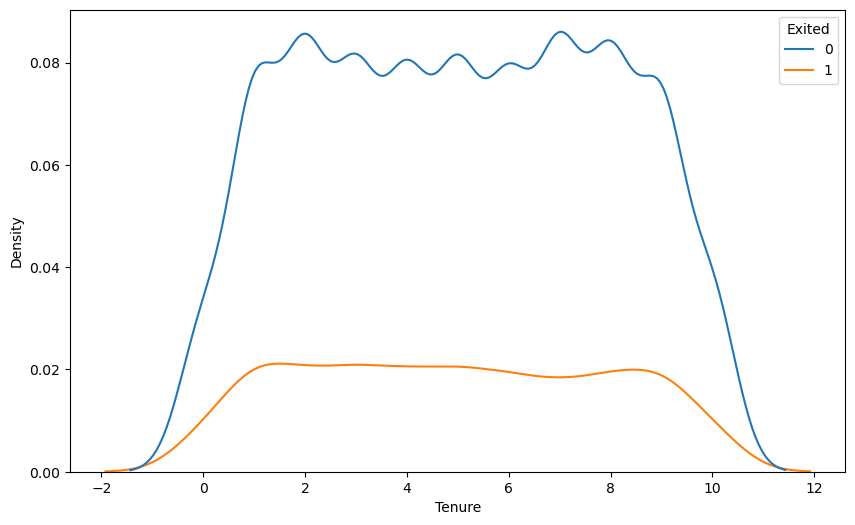

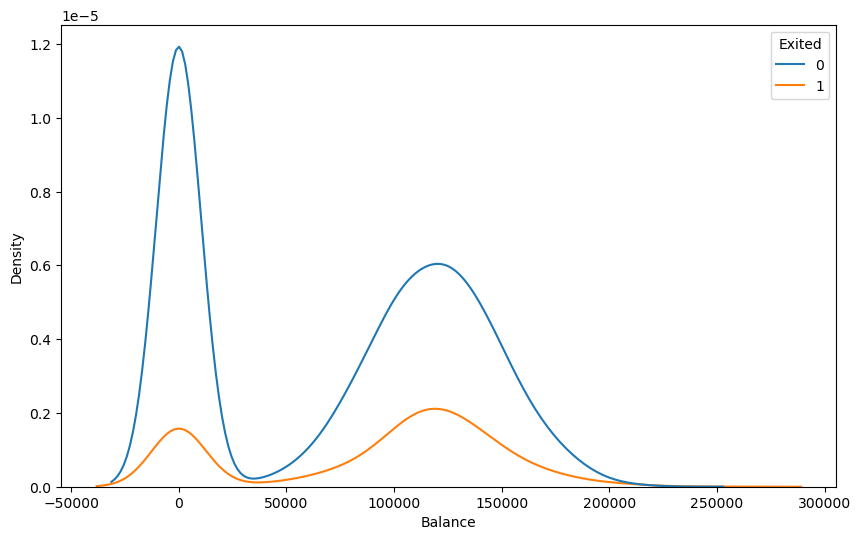

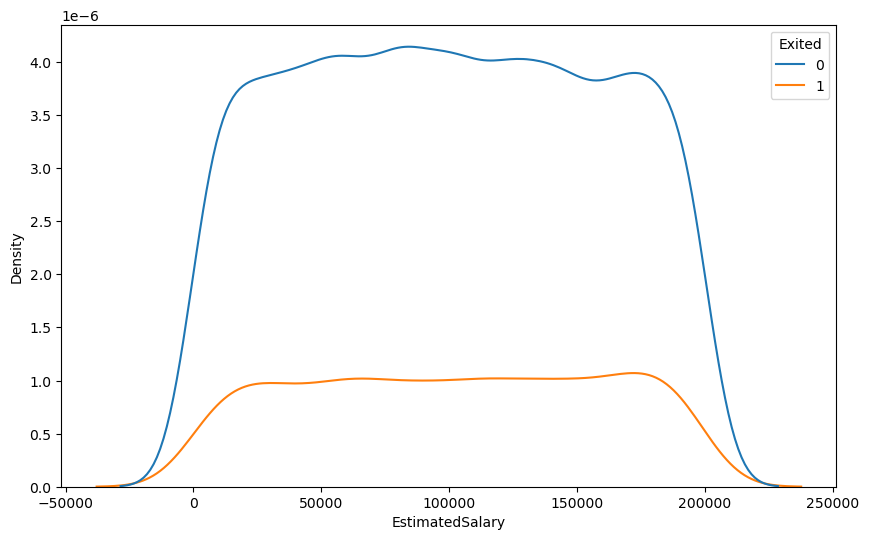

In [24]:
for i, numCol in enumerate(NumericColmuns):
    plt.figure(i, figsize=(10,6))
    sns.kdeplot(df_processed, x=numCol,hue="Exited")
    plt.show()

Никаких инсайдов не получено, распределения примерно совпадают по формам у групп ушедших и не ушедших клиентов

## Категориальные и бинарные признаки

In [25]:
def categoryUnivariateAnalysis(df,category,target):
    plt.figure(figsize=(8,6))
    sns.countplot(df,x=category,hue=target)
    plt.show()
    
    for cat in df[category].unique():
        total = df[df[category] == cat].shape[0]
        
        exited = df[(df[category] == cat) & (df[target] == 1)].shape[0]
        
        print(category, cat)
        print("Общее количество клиентов:", total)
        print("Количество ушедших:", exited)
        print("Доля ушедших: {:.2f}%\n".format((exited / total) * 100))

### Geograpy

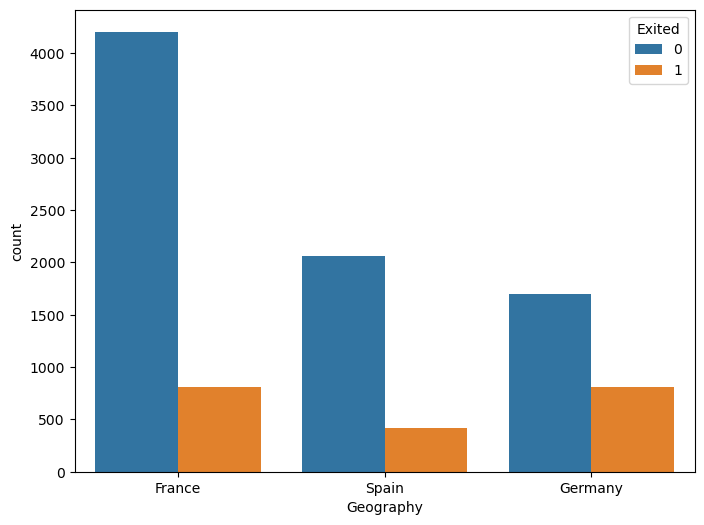

Geography France
Общее количество клиентов: 5014
Количество ушедших: 810
Доля ушедших: 16.15%

Geography Spain
Общее количество клиентов: 2477
Количество ушедших: 413
Доля ушедших: 16.67%

Geography Germany
Общее количество клиентов: 2509
Количество ушедших: 814
Доля ушедших: 32.44%



In [26]:
categoryUnivariateAnalysis(df_processed, "Geography", "Exited")

В Германии меньше всего клиентов, но доля ушедших у них в 2 раза больше, чем в других странах

Соответственно клиенты из Германии более склонны к уходу

## Gender

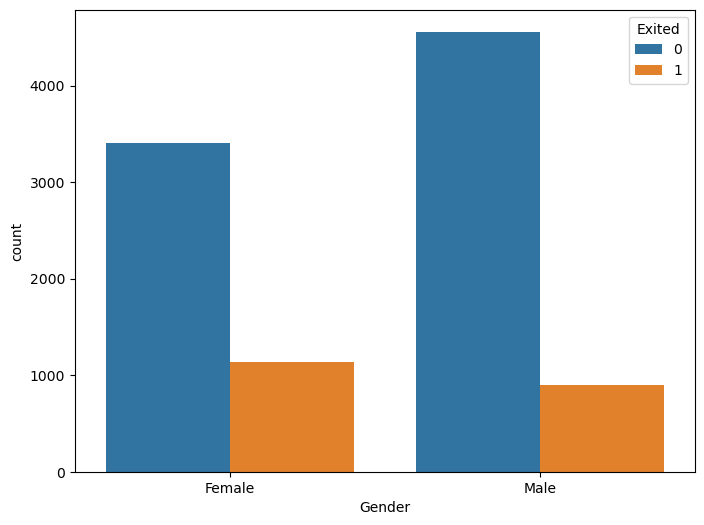

Gender Female
Общее количество клиентов: 4543
Количество ушедших: 1139
Доля ушедших: 25.07%

Gender Male
Общее количество клиентов: 5457
Количество ушедших: 898
Доля ушедших: 16.46%



In [27]:
categoryUnivariateAnalysis(df_processed, "Gender", "Exited")

Видим, что доля ушедших женщин значительно больше, чем мужчин.

### Age

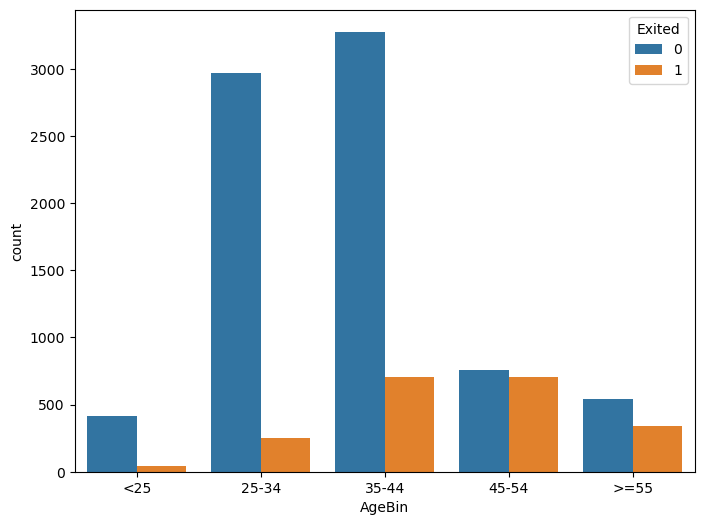

AgeBin 35-44
Общее количество клиентов: 3981
Количество ушедших: 703
Доля ушедших: 17.66%

AgeBin 45-54
Общее количество клиентов: 1458
Количество ушедших: 702
Доля ушедших: 48.15%

AgeBin 25-34
Общее количество клиентов: 3222
Количество ушедших: 250
Доля ушедших: 7.76%

AgeBin <25
Общее количество клиентов: 457
Количество ушедших: 40
Доля ушедших: 8.75%

AgeBin >=55
Общее количество клиентов: 882
Количество ушедших: 342
Доля ушедших: 38.78%



In [28]:
categoryUnivariateAnalysis(df_processed, "AgeBin", "Exited")

Клиенты старше 45 имеют огромную долю ушедших, тем временем клиенты моложе почти не уходят

Посмотрим также на распределение возраста, как числовой переменной, относительно числа ушедших

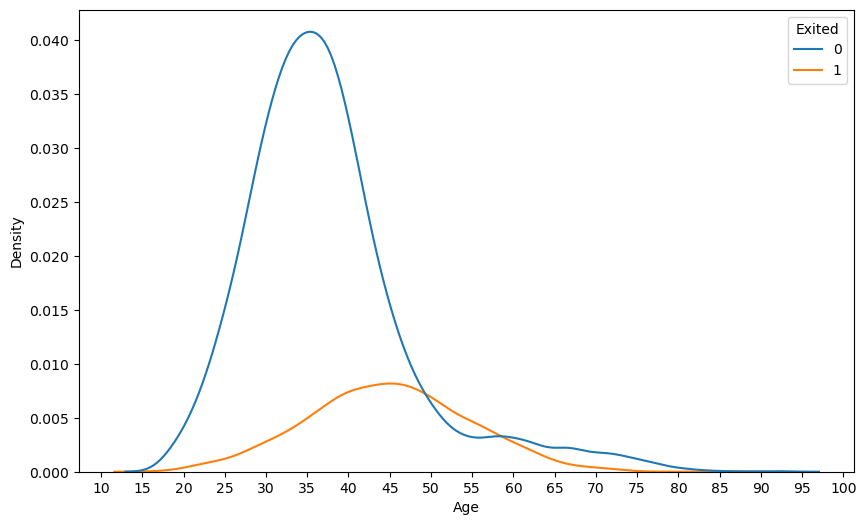

In [29]:
plt.figure(figsize=(10,6))
plot = sns.kdeplot(df, x="Age",hue="Exited")
plot.xaxis.set_major_locator(plt.MaxNLocator(20))
plt.show()

Видим, что как раз с 45 до 65 лет общее количество клиентов снижается, однако доля ушедших повышается

### CreditScore

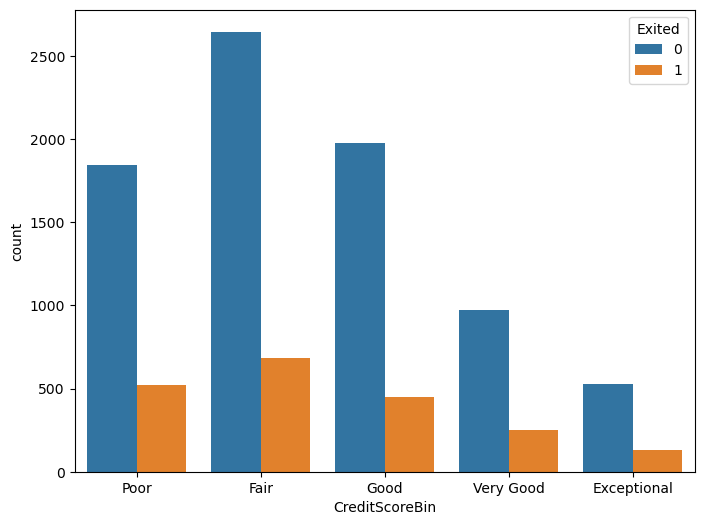

CreditScoreBin Fair
Общее количество клиентов: 3331
Количество ушедших: 685
Доля ушедших: 20.56%

CreditScoreBin Poor
Общее количество клиентов: 2362
Количество ушедших: 520
Доля ушедших: 22.02%

CreditScoreBin Good
Общее количество клиентов: 2428
Количество ушедших: 452
Доля ушедших: 18.62%

CreditScoreBin Exceptional
Общее количество клиентов: 655
Количество ушедших: 128
Доля ушедших: 19.54%

CreditScoreBin Very Good
Общее количество клиентов: 1224
Количество ушедших: 252
Доля ушедших: 20.59%



In [30]:
categoryUnivariateAnalysis(df_processed, "CreditScoreBin", "Exited")

Доля ушедших по всем категориям кредитоспособности примерно равна. У группы оценненой как хуже всего кредитоспособной процент ушедших больше всего, что в целом интуитивно понятно.

Тем не менее никаких явных инсайдов.

### NumOfProducts

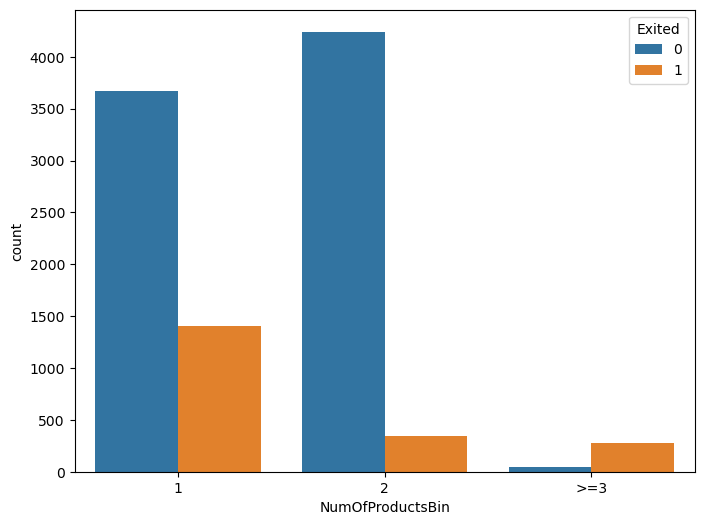

NumOfProductsBin 1
Общее количество клиентов: 5084
Количество ушедших: 1409
Доля ушедших: 27.71%

NumOfProductsBin >=3
Общее количество клиентов: 326
Количество ушедших: 280
Доля ушедших: 85.89%

NumOfProductsBin 2
Общее количество клиентов: 4590
Количество ушедших: 348
Доля ушедших: 7.58%



In [31]:
categoryUnivariateAnalysis(df_processed, "NumOfProductsBin", "Exited")

Видим, что меньше всего ушедших в группе с двумя продуктами.

В группе с одним продуктом достаточно большая доля ушедших, что интуитвно понятно: клиент начал пользоваться услугами банка и понял, что ему больше подходит другой.

Однако в группе с 3 и более продуктами интереснее. Более 85% из них ушло и нужно узнать почему.

### HasCrCard

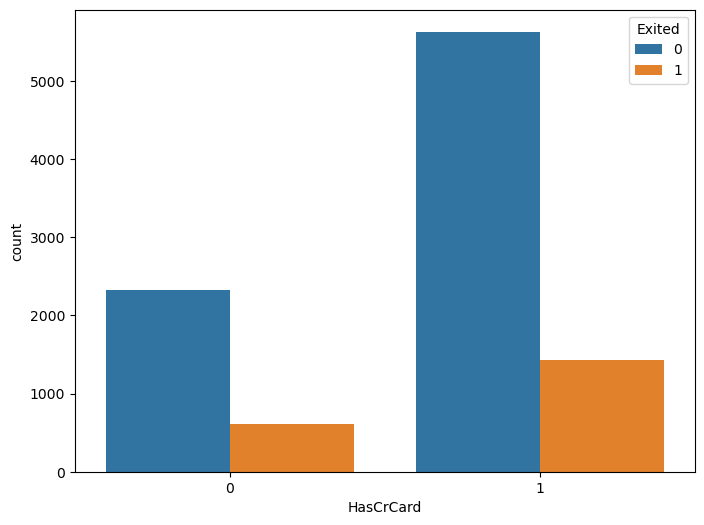

HasCrCard 1
Общее количество клиентов: 7055
Количество ушедших: 1424
Доля ушедших: 20.18%

HasCrCard 0
Общее количество клиентов: 2945
Количество ушедших: 613
Доля ушедших: 20.81%



In [32]:
categoryUnivariateAnalysis(df_processed, "HasCrCard", "Exited")

Тут доля почти одинакова, никаких инсайдов.

### IsActiveMember

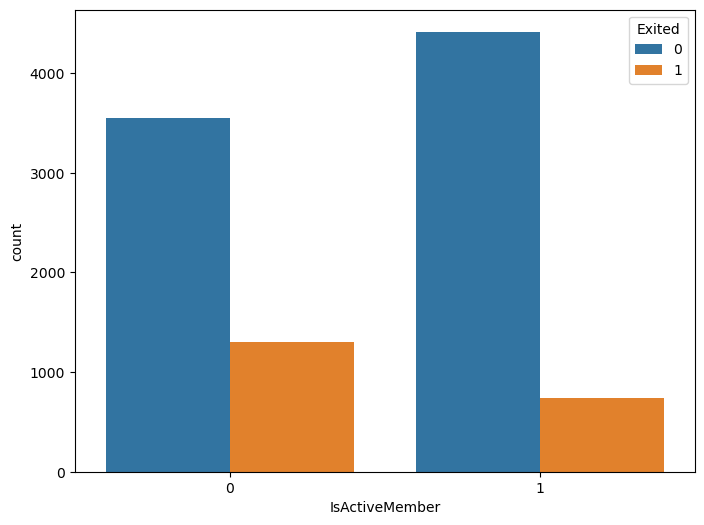

IsActiveMember 1
Общее количество клиентов: 5151
Количество ушедших: 735
Доля ушедших: 14.27%

IsActiveMember 0
Общее количество клиентов: 4849
Количество ушедших: 1302
Доля ушедших: 26.85%



In [33]:
categoryUnivariateAnalysis(df_processed, "IsActiveMember", "Exited")

Доля ушедших клиентов среди неактивных почти в 2 раза больше, чем среди активных. Это довольно интуитивно понятно, тем не менее неактивным пользователям нужно уделить особое внимание.

# Двумерный анализ

Тут посмотрим комбинации признаков, давших какие-то инсайды на этапе одномерного анализа, относительно целевого признака.

Также обратим внимание и на признаки, не давшие никаких инсайдов на предыдущем этапе.

Для начала выпишем признаки, показавшие себя информативными на этапе одномерного анализа:
1. Balance - очень большое количество клиентов с нулевым балансом (36%), при этом доля ушедших больше среди клиентов с ненулевым балансом  (24%)
2. Geography - в Германии доля ушедших клиентов (32%) в 2 раза больше, чем в других странах (~16%)
3. Gender - доля ушедших женщин (25%) почти в 2 раза больше доле ушедших мужчин (16%)
4. Age - клиенты в возрасте от 45 и до 65 имеют значительно большую долю ушедших, чем остальные возрастные группы 
5. NumOfProcuts - клиенты с тремя и более продуктами имеют долю ушедших 85%
6. IsActiveMember - доля ушедших неактивных клиентов (27%) почти в 2 раза больше чем у активных (14%)

Сейчас разделим датасет на две группы по целевому признаку и будем строить по два графика для анализа зависимости двух категориальных признаков, относительно целевого

In [34]:
df_exited = df_processed[df_processed["Exited"] == 1]
df_nonexited = df_processed[df_processed["Exited"] == 0]

In [35]:
def categoryBivariateAnalysis(df_0,df_1, column, hue, figsize=(8,6)):
    hue_values = df_0[hue].unique()
    hue_order = sorted(hue_values) 

    palette = sns.color_palette("husl", n_colors=len(hue_order))
    palette = dict(zip(hue_order, palette))
    
    plt.figure(figsize=figsize)
    sns.countplot(df_0, x=column, hue=hue,hue_order=hue_order, palette=palette)
    plt.title(column + " / " + hue + " для неушедших")
    plt.show()
    
    plt.figure(figsize=figsize)
    sns.countplot(df_1, x=column, hue=hue,hue_order=hue_order, palette=palette)
    plt.title(column + " / " + hue + " для ушедших")
    plt.show()
    

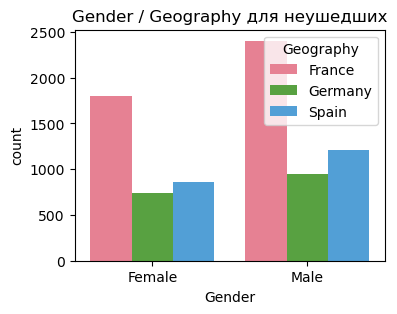

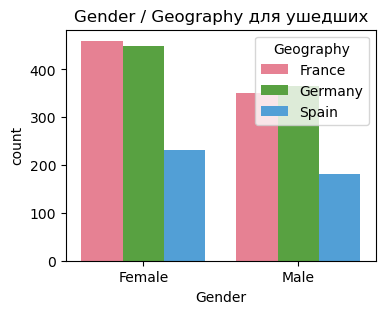

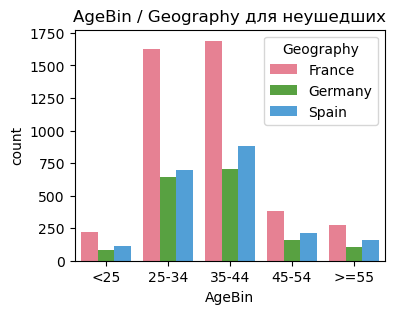

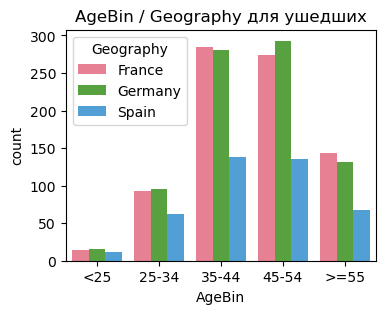

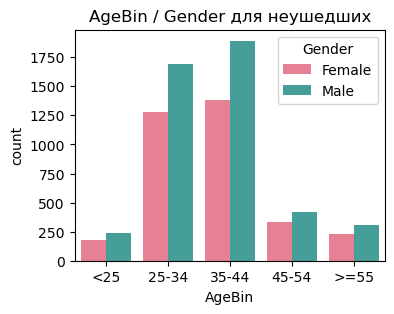

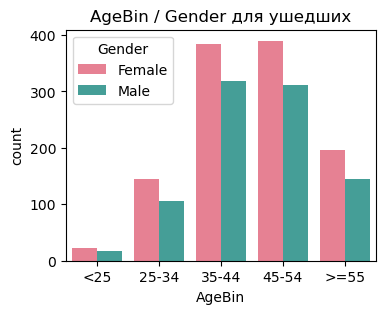

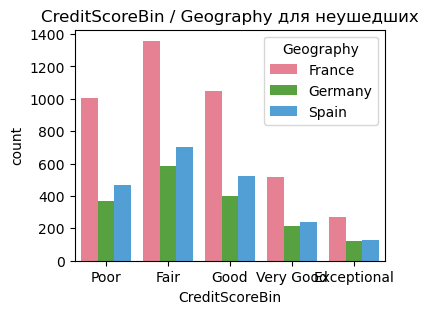

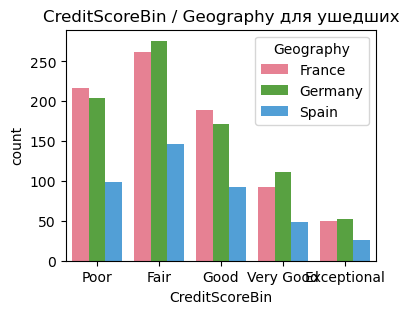

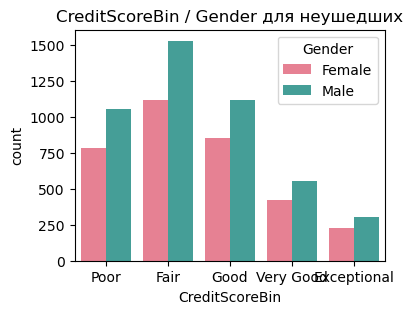

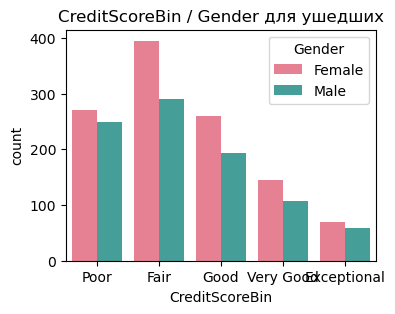

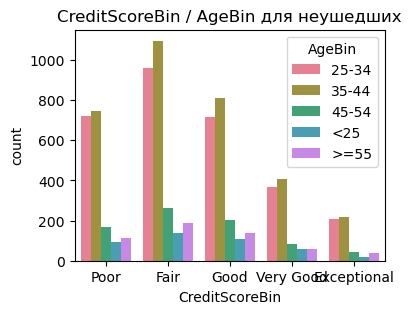

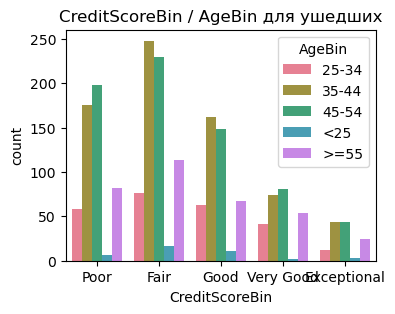

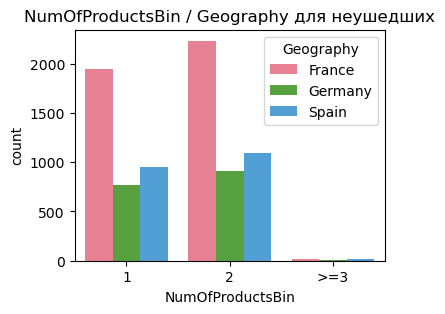

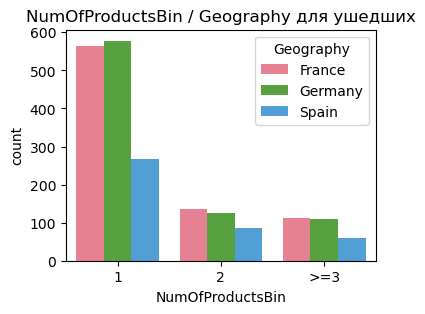

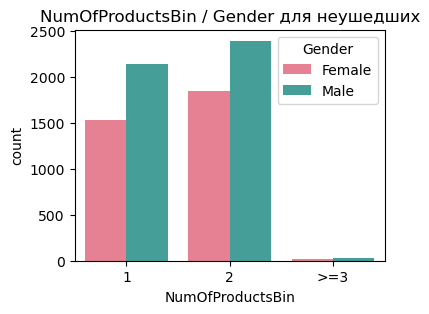

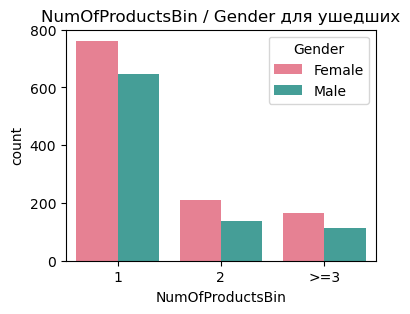

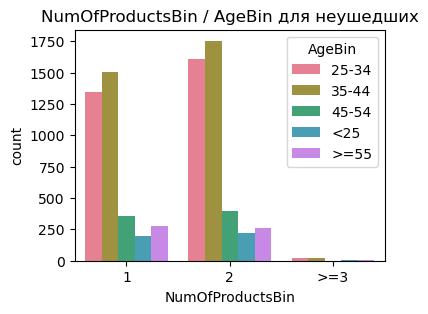

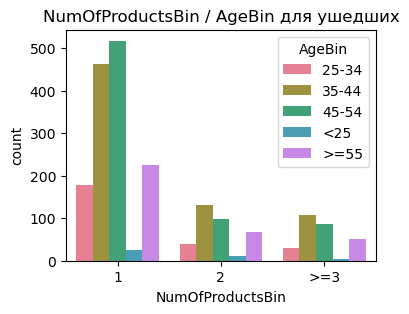

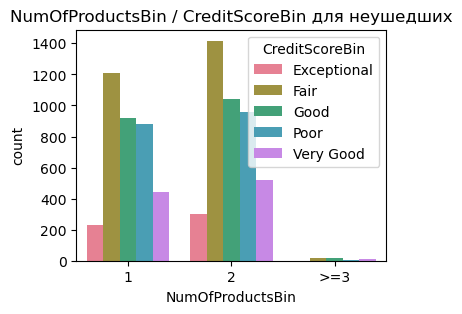

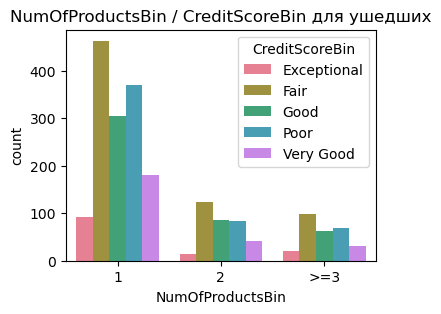

In [36]:
for i, colName1 in enumerate(CategoricalColumns):
    for j, colName2 in enumerate(CategoricalColumns):
        if(i > j):
            categoryBivariateAnalysis(df_nonexited,df_exited,colName1, colName2, (4,3))

Никаких новых инсайдов, по большей части все соответствует уже найденным ранее

<Axes: title={'center': 'Balance'}, xlabel='Geography'>

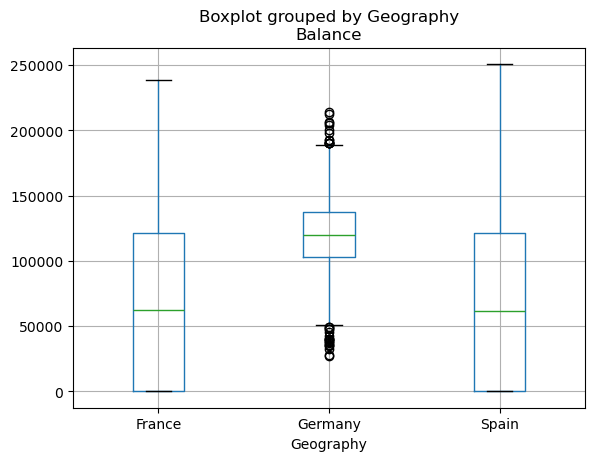

In [37]:
df_processed.boxplot(column="Balance", by="Geography")

В Германии нет клиентов с нулевым балансом и в целом балансы клиентов в Германии значительно выше, чем в других странах.

# Корреляция

Ниже приведем все признаки к числовым и проведем анализ корреляции отдельных признаков с Exited 

In [38]:
df_dummied = pd.get_dummies(df_processed, columns=CategoricalColumns+BooleanColumns, drop_first=True)

df_dummied.head()

,Tenure,Balance,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male,AgeBin_25-34,AgeBin_35-44,AgeBin_45-54,AgeBin_>=55,CreditScoreBin_Fair,CreditScoreBin_Good,CreditScoreBin_Very Good,CreditScoreBin_Exceptional,NumOfProductsBin_2,NumOfProductsBin_>=3,HasCrCard_1,IsActiveMember_1
RowNumber,,,,,,,,,,,,,,,,,,,
1,2,0.00,101348.88,1,False,False,False,False,True,False,False,True,False,False,False,False,False,True,True
2,1,83807.86,112542.58,0,False,True,False,False,True,False,False,True,False,False,False,False,False,False,True
3,8,159660.80,113931.57,1,False,False,False,False,True,False,False,False,False,False,False,False,True,True,False
4,1,0.00,93826.63,0,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False
5,2,125510.82,79084.10,0,False,True,False,False,True,False,False,False,False,False,True,False,False,True,True


In [39]:
corr = df_dummied.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
annot = np.where((np.abs(corr) > 0.15) & ~mask, corr.round(2), "")

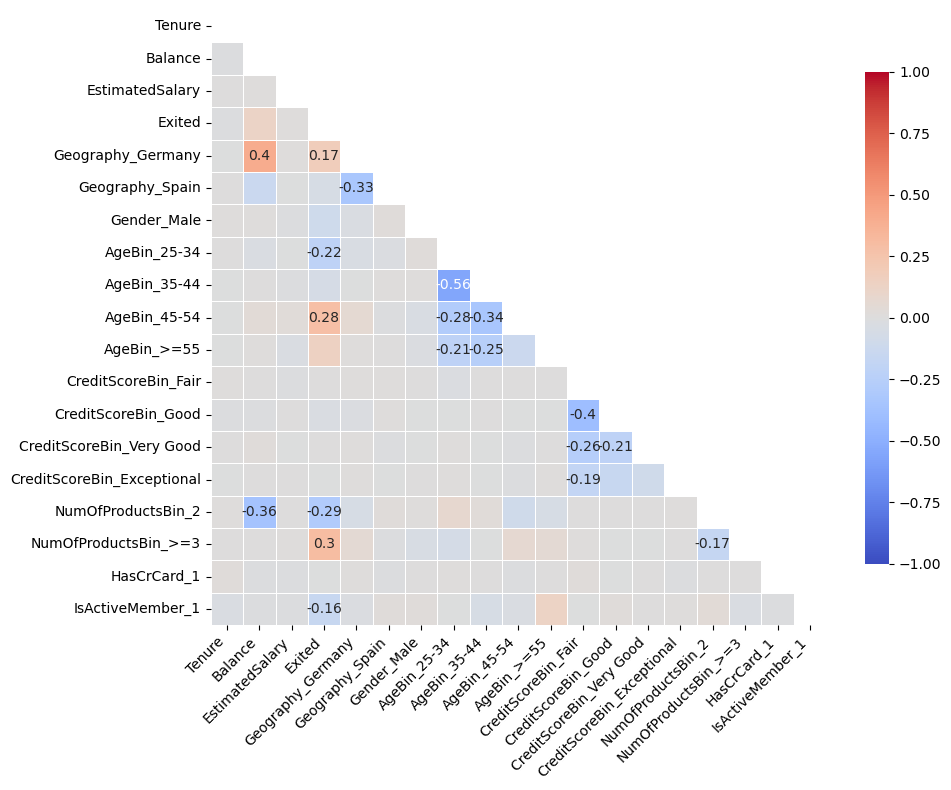

In [40]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    mask=mask, 
    annot=annot, 
    fmt="", 
    cmap="coolwarm",
    center=0,
    vmin=-1, vmax=1, 
    linewidths=0.5, 
    cbar_kws={"shrink": 0.8} 
)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Видим, что нахождение в Германии, количество продуктов больше трех и возраст от 45-54 очень хорошо коррелируют с уходом. Из интересного клиенты в возрасте от 25 до 34, клиенты с двумя продуктами и активные клиенты сильно отрицательно коррелируют с целевой переменной - значит эти группы являются стабильными клиентами

<Axes: >

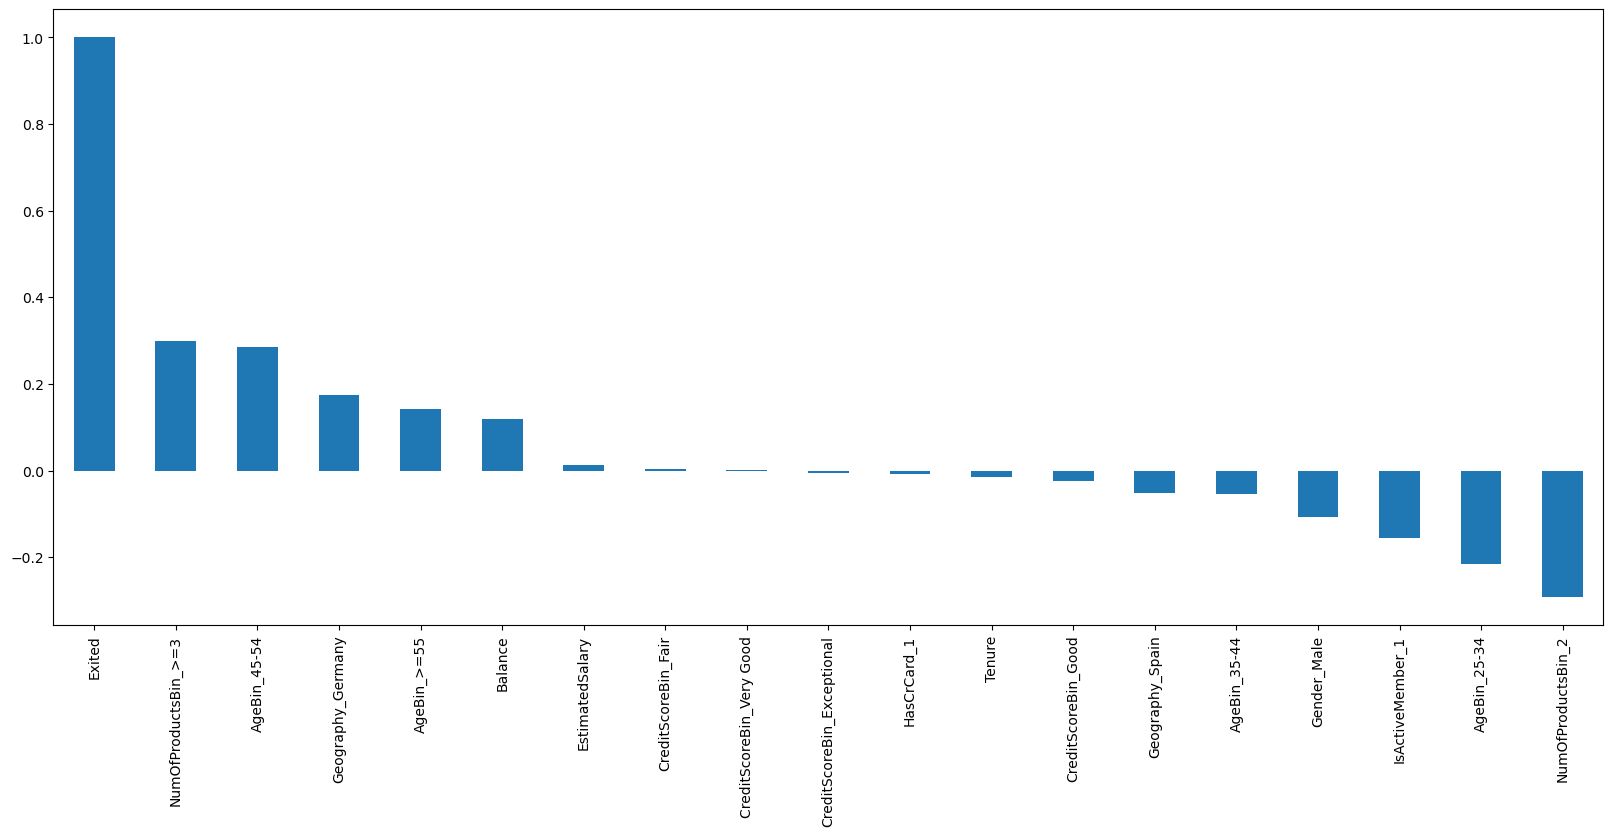

In [41]:
plt.figure(figsize=(20,8))
df_dummied.corr()['Exited'].sort_values(ascending=False).plot(kind="bar")

# Статистические тесты 

Проведем статистические тесты для проверки полученных гипотез.

## Взаимосвязь Exited и Geography

Для того, чтобы определить есть ли взаимосвязь между Exited и Geography проведем Хи-квадрат тест.

In [42]:
from scipy.stats import chi2_contingency

H0: Доля ушедших клиентов не зависит от страны

H1: Доля ушедших клиентов различается между странами

In [43]:
contin_geography_churn = pd.crosstab(df_processed['Geography'], df_processed['Exited'])

chi2, p_value, dof, expected = chi2_contingency(contin_geography_churn)
n = contin_geography_churn.sum().sum()
V = np.sqrt(chi2 / (n * (min(contin_geography_churn.shape) - 1)))

print(f"χ² = {chi2:.2f}, p-value = {p_value:.4f}")
print(f"Cramer's V = {V:.3f}")
print("Ожидаемые частоты:\n", expected)

χ² = 301.26, p-value = 0.0000
Cramer's V = 0.174
Ожидаемые частоты:
 [[3992.6482 1021.3518]
 [1997.9167  511.0833]
 [1972.4351  504.5649]]


p-value < 0.05 => Отвергаем нулевую гипотезу. Тем не менее Cramer's V = 0.174, что соответствует слабой связи. То есть страна влияет, но это не главный фактор.

## Взаимосвязь Exited и Gender

Для того, чтобы проверить есть ли взаимосвязь между Gender и Exited, также проведем тест Хи-квадрат

H0: Доля ушедших клиентов не зависит от пола

H1: Доля ушедших клиентов различается между полами

In [44]:
contin_gender_churn = pd.crosstab(df_processed['Gender'], df_processed['Exited'])

chi2, p_value, dof, expected = chi2_contingency(contin_gender_churn)
n = contin_geography_churn.sum().sum()
V = np.sqrt(chi2 / (n * (min(contin_geography_churn.shape) - 1)))

print(f"χ² = {chi2:.2f}, p-value = {p_value:.4f}")
print(f"Cramer's V = {V:.3f}")
print("Ожидаемые частоты:\n", expected)

χ² = 112.92, p-value = 0.0000
Cramer's V = 0.106
Ожидаемые частоты:
 [[3617.5909  925.4091]
 [4345.4091 1111.5909]]


p-value < 0.05 => Отвергаем нулевую гипотезу. Тем не менее Cramer's V = 0.106, что соответствует нижней границы слабой связи. То есть пол также влияет, но это не главный фактор.

## Взаимосвязь Exited и NumOfProducts

Для того, чтобы проверить есть ли взаимосвязь между NumOfProducts и Exited, также проведем тест Хи-квадрат

H0: Доля ушедших клиентов не зависит от количества продуктов

H1: Доля ушедших клиентов различается в зависимости от количества продуктов

In [45]:
contin_products_churn = pd.crosstab(df_processed['NumOfProductsBin'], df_processed['Exited'])

chi2, p_value, dof, expected = chi2_contingency(contin_products_churn)
n = contin_geography_churn.sum().sum()
V = np.sqrt(chi2 / (n * (min(contin_products_churn.shape) - 1)))

print(f"χ² = {chi2:.2f}, p-value = {p_value:.4f}")
print(f"Cramer's V = {V:.3f}")
print("Ожидаемые частоты:\n", expected)

χ² = 1494.60, p-value = 0.0000
Cramer's V = 0.387
Ожидаемые частоты:
 [[4048.3892 1035.6108]
 [3655.017   934.983 ]
 [ 259.5938   66.4062]]


p-value < 0.05 => Отвергаем нулевую гипотезу. Cramer's V = 0.387, что соответствует умеренной связи. Это уже значимый результат, целевой признак зависит от количества продуктов.

## Взаимосвязь Exited и Age

Для того, чтобы проверить есть ли взаимосвязь между NumOfProducts и Exited, проведем тест Хи-квадрат

H0: Доля ушедших клиентов не зависит от возраста

H1: Доля ушедших клиентов различается в зависимости от возраста

In [46]:
contin_age_churn = pd.crosstab(df_processed['AgeBin'], df_processed['Exited'])

chi2, p_value, dof, expected = chi2_contingency(contin_age_churn)
n = contin_geography_churn.sum().sum()
V = np.sqrt(chi2 / (n * (min(contin_age_churn.shape) - 1)))

print(f"χ² = {chi2:.2f}, p-value = {p_value:.4f}")
print(f"Cramer's V = {V:.3f}")
print("Ожидаемые частоты:\n", expected)

χ² = 1249.74, p-value = 0.0000
Cramer's V = 0.354
Ожидаемые частоты:
 [[ 363.9091   93.0909]
 [2565.6786  656.3214]
 [3170.0703  810.9297]
 [1161.0054  296.9946]
 [ 702.3366  179.6634]]


p-value < 0.05 => Отвергаем нулевую гипотезу. Cramer's V = 0.354, что также соответствует умеренной связи. Это также значимый результат.

## Взаимосвязь Exited и IsActiveMember

Для того, чтобы проверить есть ли взаимосвязь между NumOfProducts и IsActiveMember, проведем тест Хи-квадрат

H0: Доля ушедших клиентов не зависит от активности

H1: Доля ушедших клиентов различается в зависимости от активности

In [47]:
contin_active_churn = pd.crosstab(df_processed['IsActiveMember'], df_processed['Exited'])

chi2, p_value, dof, expected = chi2_contingency(contin_active_churn)
n = contin_geography_churn.sum().sum()
V = np.sqrt(chi2 / (n * (min(contin_active_churn.shape) - 1)))

print(f"χ² = {chi2:.2f}, p-value = {p_value:.4f}")
print(f"Cramer's V = {V:.3f}")
print("Ожидаемые частоты:\n", expected)

χ² = 242.99, p-value = 0.0000
Cramer's V = 0.156
Ожидаемые частоты:
 [[3861.2587  987.7413]
 [4101.7413 1049.2587]]


p-value < 0.05 => Отвергаем нулевую гипотезу. Cramer's V = 0.156, что соответствует слабой связи.